# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [10]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [120]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
test_X_raw = test_X
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [12]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [13]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [14]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for hidden_layer.W
Gradient check passed!
Checking gradient for hidden_layer.B
Gradient check passed!
Checking gradient for output_layer.W
Gradient check passed!
Checking gradient for output_layer.B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [15]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for hidden_layer.W
Gradient check passed!
Checking gradient for hidden_layer.B
Gradient check passed!
Checking gradient for output_layer.W
Gradient check passed!
Checking gradient for output_layer.B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [16]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [147]:
np.random.seed(42)
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.275189, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.232763, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228469, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.225924, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221809, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211520, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.190569, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.162676, Train accuracy: 0.204889, val accuracy: 0.212000
Loss: 2.132737, Train accuracy: 0.236333, val accuracy: 0.240000
Loss: 2.100915, Train accuracy: 0.265000, val accuracy: 0.262000
Loss: 2.064470, Train accuracy: 0.274556, val accuracy: 0.273000
Loss: 2.017838, Train accuracy: 0.285667, val accuracy: 0.289000
Loss: 1.961756, Train accuracy: 0.320667, val accuracy: 0.328000
Loss: 1.899850, Train accuracy: 0.353778, val accuracy: 0.351000
Loss: 1.835028, Train acc

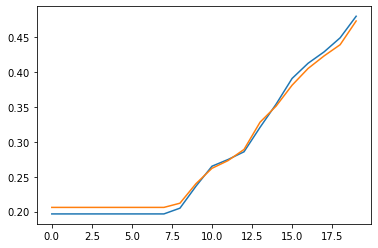

In [148]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [150]:
np.random.seed(42)
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=2e-2, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.260272, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231080, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224401, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.203371, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.154236, Train accuracy: 0.223667, val accuracy: 0.226000
Loss: 2.096852, Train accuracy: 0.272222, val accuracy: 0.271000
Loss: 2.020011, Train accuracy: 0.299222, val accuracy: 0.303000
Loss: 1.910934, Train accuracy: 0.357778, val accuracy: 0.360000
Loss: 1.794461, Train accuracy: 0.413111, val accuracy: 0.404000
Loss: 1.697571, Train accuracy: 0.442111, val accuracy: 0.432000
Loss: 1.616738, Train accuracy: 0.492667, val accuracy: 0.485000
Loss: 1.547866, Train accuracy: 0.524556, val accuracy: 0.514000
Loss: 1.479520, Train accuracy: 0.554333, val accuracy: 0.544000
Loss: 1.417659, Train accuracy: 0.586222, val accuracy: 0.580000
Loss: 1.364958, Train accuracy: 0.610667, val accuracy: 0.600000
Loss: 1.316965, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [151]:
np.random.seed(42)
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=2e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.172451, Train accuracy: 0.332444, val accuracy: 0.333000
Loss: 1.682079, Train accuracy: 0.538667, val accuracy: 0.540000
Loss: 1.438796, Train accuracy: 0.614889, val accuracy: 0.598000
Loss: 1.360145, Train accuracy: 0.639444, val accuracy: 0.611000
Loss: 1.297174, Train accuracy: 0.693111, val accuracy: 0.669000
Loss: 1.264913, Train accuracy: 0.616222, val accuracy: 0.586000
Loss: 1.245545, Train accuracy: 0.705222, val accuracy: 0.633000
Loss: 1.231916, Train accuracy: 0.707444, val accuracy: 0.664000
Loss: 1.210224, Train accuracy: 0.717222, val accuracy: 0.661000
Loss: 1.199765, Train accuracy: 0.737889, val accuracy: 0.673000
Loss: 1.189079, Train accuracy: 0.703333, val accuracy: 0.658000
Loss: 1.181136, Train accuracy: 0.765667, val accuracy: 0.710000
Loss: 1.180868, Train accuracy: 0.718444, val accuracy: 0.664000
Loss: 1.160581, Train accuracy: 0.758111, val accuracy: 0.683000
Loss: 1.144957, Train accuracy: 0.742111, val accuracy: 0.668000
Loss: 1.140496, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [152]:
np.random.seed(42)
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.334485, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.318682, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310545, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.292216, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280550, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.267961, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.250311, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.223449, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.169301, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.099030, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.101063, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.985293, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.952226, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.913096, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.829116, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.805463, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [153]:
np.random.seed(42)
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e0, num_epochs=20, batch_size=5, learning_rate_decay=0.859)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.327381, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.232175, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.195465, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.973390, Train accuracy: 0.333333, val accuracy: 0.200000
Loss: 3.218485, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 8.005314, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 17.451712, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 28.381817, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 73.079071, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 21.323413, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 3.845423, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 5.170656, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.729443, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 0.583301, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.519680, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.462385, Train

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [188]:
np.random.seed(42)
# Let's train the best one-hidden-layer network we can

learning_rate = 3e-3
reg_strength = 3e-3
learning_rate_decay = 0.97
hidden_layer_size = 64*6
num_epochs = 100
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=num_epochs, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

best_classifier = model
best_val_accuracy = val_history[-1]

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.254491, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226028, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.184518, Train accuracy: 0.213444, val accuracy: 0.220000
Loss: 2.109128, Train accuracy: 0.270556, val accuracy: 0.274000
Loss: 2.002952, Train accuracy: 0.341000, val accuracy: 0.350000
Loss: 1.861875, Train accuracy: 0.399111, val accuracy: 0.387000
Loss: 1.744178, Train accuracy: 0.469000, val accuracy: 0.449000
Loss: 1.653810, Train accuracy: 0.521111, val accuracy: 0.518000
Loss: 1.577550, Train accuracy: 0.561222, val accuracy: 0.548000
Loss: 1.514894, Train accuracy: 0.584000, val accuracy: 0.581000
Loss: 1.468524, Train accuracy: 0.616556, val accuracy: 0.593000
Loss: 1.424952, Train accuracy: 0.631111, val accuracy: 0.615000
Loss: 1.394469, Train accuracy: 0.653222, val accuracy: 0.645000
Loss: 1.368323, Train accuracy: 0.670222, val accuracy: 0.650000
Loss: 1.347796, Train accuracy: 0.676111, val accuracy: 0.657000
Loss: 1.332623, Train acc

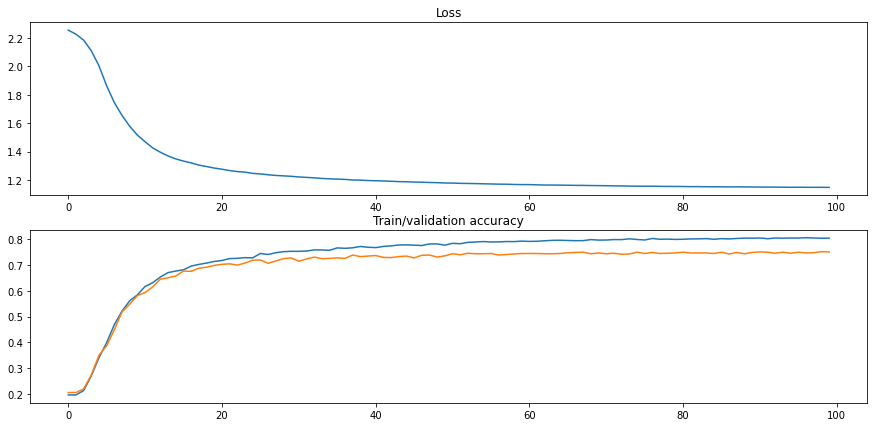

In [189]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [190]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.708000


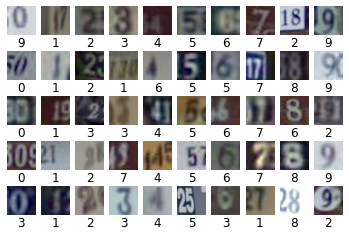

In [191]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = test_X_raw[test_y == class_index][example_index]
        prediction = test_pred[test_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plt.title(prediction, y=-0.6)
        plot_index += 1


In [ ]:
2 0 1 2 1 0 1 1 2 2 = 12 / 50 = 24/100 = 1 - 76/100